# '<p style="text-align: center">Predict Heart Disease</p>'
## Using K-Nearest Neighbors

There are multiple risk factors that could contribute to CVD(cardiovascular diseases) in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

We are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future.


## Introduction
The dataset has the following features:

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
heart=pd.read_csv('heart_disease_prediction.csv')

print(heart.shape)

(918, 12)


In [4]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Here are a few summaries after reviewing the descriptive statistics:

1. There are no missing values in the dataset.
2. The average age of the patients is 53.5 years old
3. There are some data abnormalities: "RestingBP"  has the minimum value of 0;"Cholesterol" has a minimum value of 0 and 603 for the max.


## EDA: Categorical Data

We confirmed all categorical columns including HeartDisease and FastingBS(although they are labeled as "int64"). Let's create a bar chart for each variable to explore the data distribution.

In [7]:
# let's have all categorical columns in a list

cat_cols=list(heart.select_dtypes(include=['object']).columns)
cat_cols.append('HeartDisease')
cat_cols.append('FastingBS')

In [8]:
cat_cols

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'HeartDisease',
 'FastingBS']

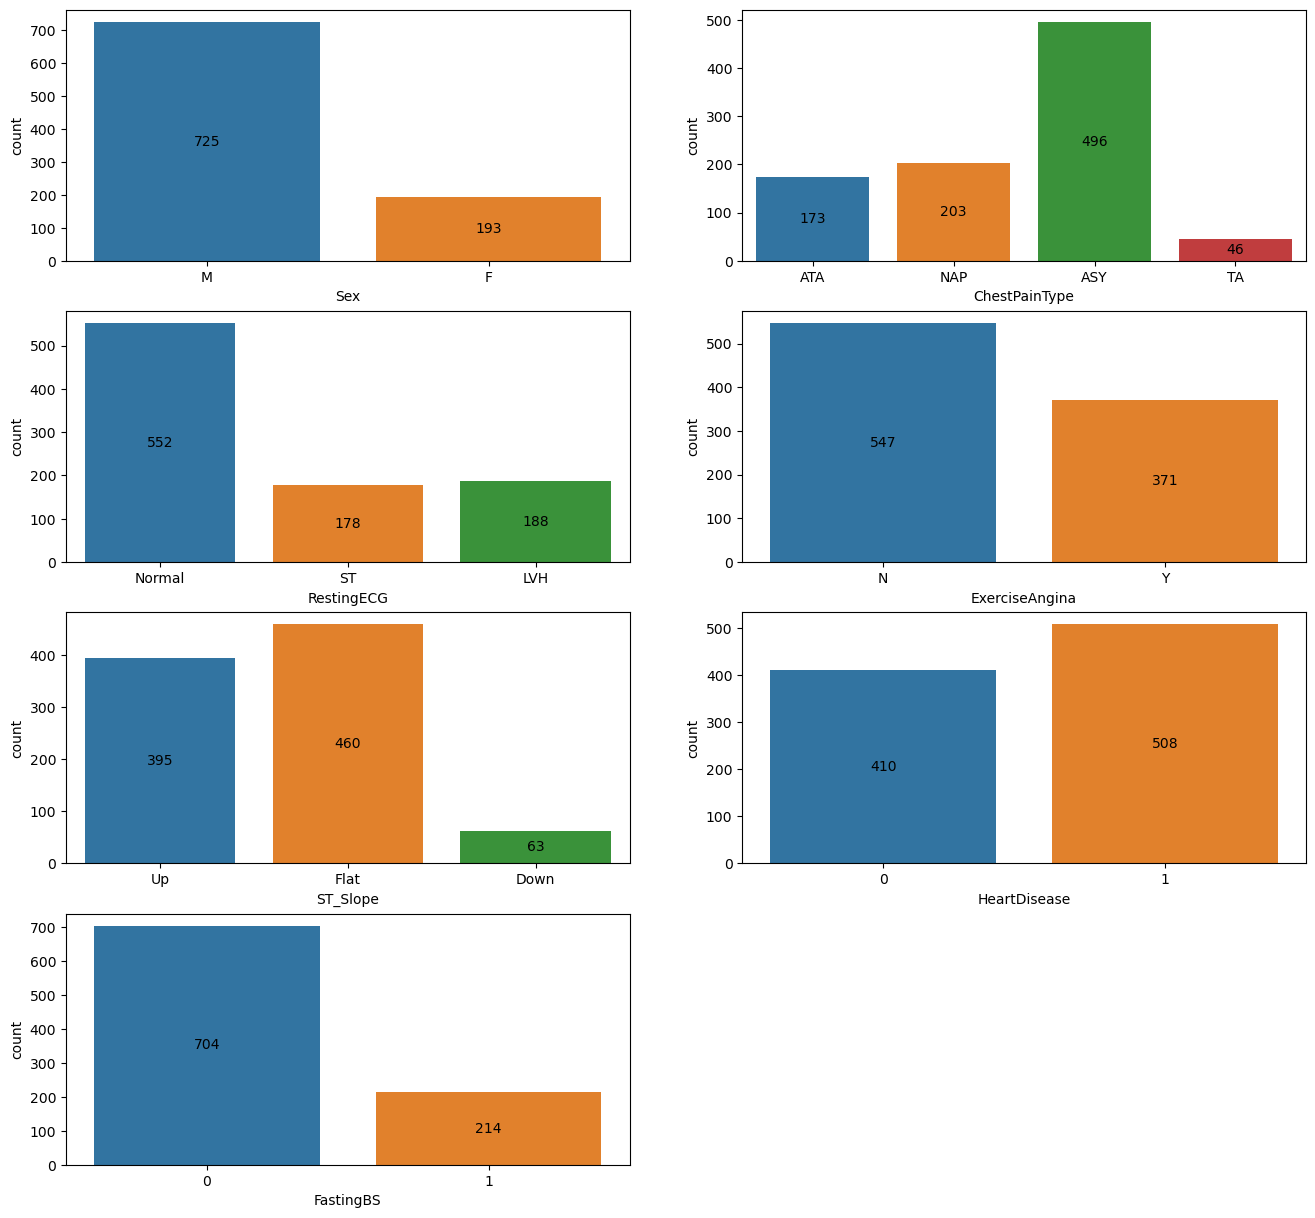

In [9]:
fig=plt.figure(figsize=(16,15))

for idex, col in enumerate(cat_cols):
    ax=plt.subplot(4,2,idex+1)
    sns.countplot(x=heart[col],ax=ax)
    #add data labels to each bar plot
    for container in ax.containers:
        ax.bar_label(container,label_type="center")
    

- The dataset is highly skewed towards male patients. There are 725 male patients and 193 female patients. This could potentially induce a bias in our model.
- 496 patients had ASY (asymptotic) chest pain type.
- 552 patients had a normal restin ECG.
- 704 patients had blood sugar lower than 120 mg/dl

let's explore the variables grouped by HeartDisease column

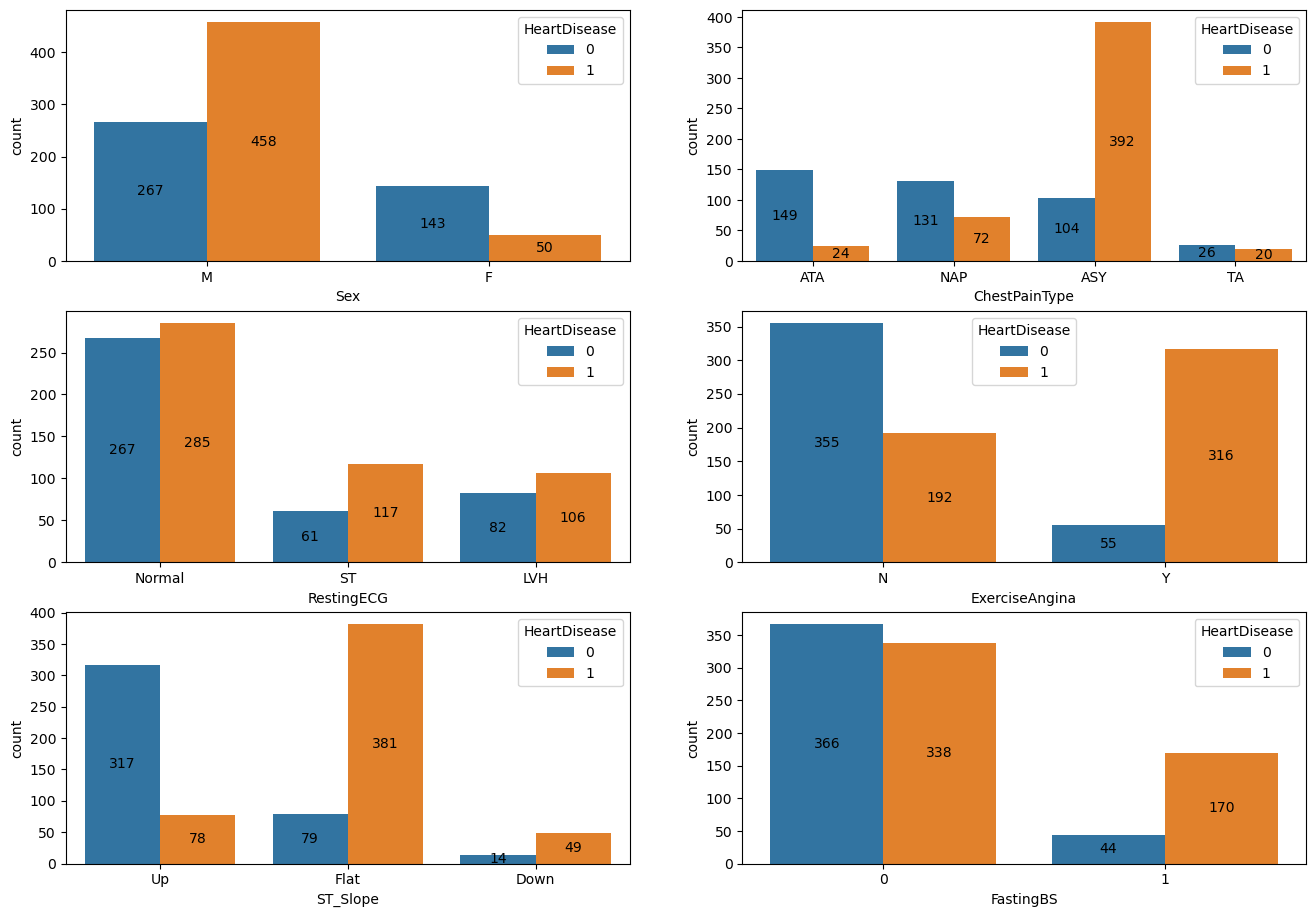

In [10]:
cat_cols.remove('HeartDisease')

fig=plt.figure(figsize=(16,15))

for idex, col in enumerate(cat_cols):
    ax=plt.subplot(4,2, idex+1)
    sns.countplot(x=heart[col],hue=heart['HeartDisease'],ax=ax)
    for container in ax.containers:
        ax.bar_label(container,label_type='center')

After reviewing the plot above, we can identify some variables that could be more associated with the heartdisease prediction.
- We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
- A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.


## Data Cleaning---Categorical Data

As we discovered at the beginning of the project, there are a few columns containing values that don't make sense( zero or negative).

There are a few options we can address the issue:
- we could remove those rows entirely if their frequency of occurence is low
- we could impute those values with the median value of the column or the meadian value of the column grouped by "HeartDisease"

Let's first explore the distribution of 'RestingBP' and 'Cholesterol'.

(array([  1.,   0.,   0.,   0.,  12., 148., 430., 234.,  73.,  20.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <BarContainer object of 10 artists>)

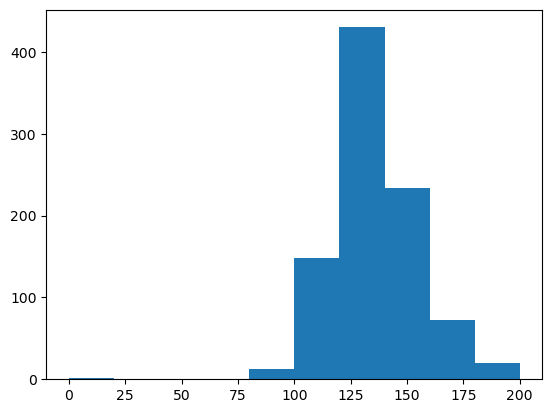

In [11]:
plt.hist(heart['RestingBP'])

(array([172.,   6.,  70., 319., 248.,  81.,  14.,   3.,   3.,   2.]),
 array([  0. ,  60.3, 120.6, 180.9, 241.2, 301.5, 361.8, 422.1, 482.4,
        542.7, 603. ]),
 <BarContainer object of 10 artists>)

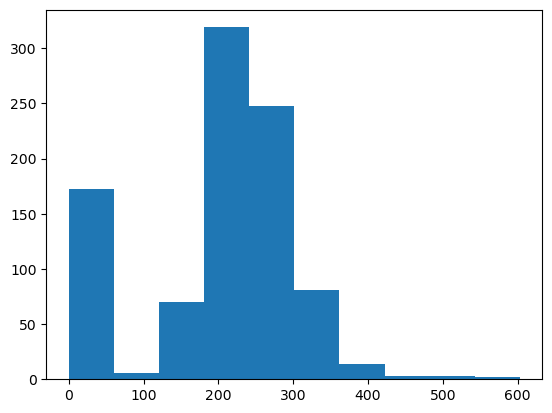

In [12]:
plt.hist(heart['Cholesterol'])

Based on the histogram, the values of 0 appear to be outliers.
Let's count the number of records with "0"

In [13]:
heart.loc[heart['RestingBP']==0,'RestingBP'].value_counts()

0    1
Name: RestingBP, dtype: int64

In [14]:
heart.loc[heart['Cholesterol']==0,'Cholesterol'].value_counts()

0    172
Name: Cholesterol, dtype: int64

- 'RestingBP' has only one "0" records, while 'Cholesterol' has 172 records of '0'.
- Since both variables have skewed distribution, for the consistence, we will replace 0 values with the median.

In [15]:
heart_clean=heart.copy()

In [16]:
heart_clean[heart_clean['RestingBP']==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [17]:
heart_clean[heart_clean['Cholesterol']==0][['Cholesterol','HeartDisease']].groupby(['HeartDisease']).value_counts()

HeartDisease  Cholesterol
0             0               20
1             0              152
dtype: int64

- After reviewing the records, we will replace '0's with the median value of NON-zero records grouped by 'HeartDisease'.

In [18]:
#replace 'RestingBP' 0 value with the median of non-zero in 'HeartDisease' group
rstbp_non_zero=heart_clean[heart_clean['RestingBP']!=0]


rstbp_non_zero_with_heartdisease=rstbp_non_zero.loc[rstbp_non_zero['HeartDisease']==1,'RestingBP']

heart_clean.loc[heart_clean['RestingBP']==0,'RestingBP']=rstbp_non_zero_with_heartdisease.median()


In [19]:
heart_clean[heart_clean['RestingBP']==0]#checking whether replacement was successful

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [20]:
#replace ' Cholesterol' 0s with the median of non-zeros in the corresponding 'Heartdisease' group

ch_non_zero=heart_clean[heart_clean['Cholesterol']!=0]

#non-zero 'Cholesterol' column with 'HeartDisease'
ch_non_zero_heartdisease=ch_non_zero.loc[ch_non_zero['HeartDisease']==1,'Cholesterol']

#non-zero 'Cholesterol' column without 'HeartDisease'
ch_non_zero_without_heartdisease=ch_non_zero.loc[ch_non_zero['HeartDisease']==0,'Cholesterol']

#mask for 0 'Cholesterol' with 'HeartDisease'
mask1=(heart_clean['HeartDisease']==1) & (heart_clean['Cholesterol']==0)

#replace 0 'Cholesterol' values with the median
heart_clean.loc[mask1,'Cholesterol']=ch_non_zero_heartdisease.median()

#mask for 0 'Cholesterol without 'HeartDisease'
mask2=(heart_clean['HeartDisease']==0)& (heart_clean['Cholesterol']==0)

#replace 0 'Cholesterol' values with the median
heart_clean.loc[mask2,'Cholesterol']=ch_non_zero_without_heartdisease.median()


In [21]:
heart_clean[heart_clean['Cholesterol']==0] #checking whether the imputation was successful

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


## Feature Selection

In this section, we will identify the features 'highly' correlated with the target variable 'HeartDisease'.

First, we will convert all categorical data into dummy variables.

In [22]:
heart_clean=pd.get_dummies(heart_clean)

In [23]:
heart_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214.0,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195.0,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Let's explore the correlations

<AxesSubplot:>

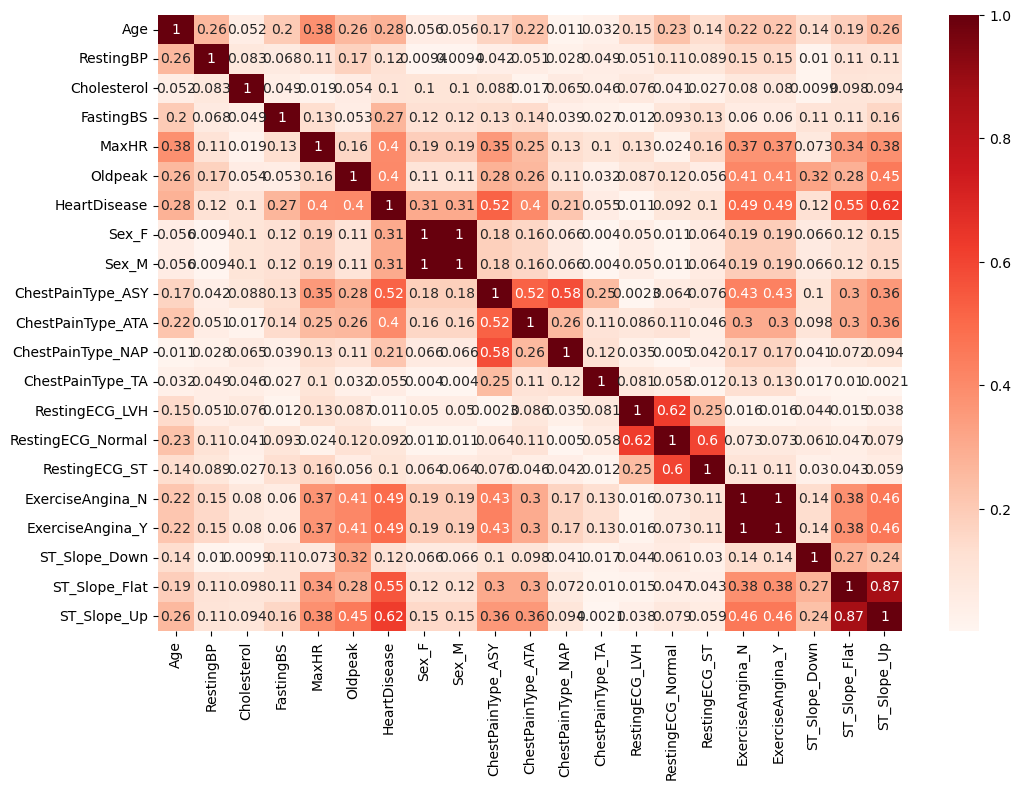

In [24]:
correlations= abs(heart_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations,annot=True, cmap="Reds")

In [25]:
correlations['HeartDisease'].nlargest(n=11)

HeartDisease         1.000000
ST_Slope_Up          0.622164
ST_Slope_Flat        0.554134
ChestPainType_ASY    0.516716
ExerciseAngina_N     0.494282
ExerciseAngina_Y     0.494282
Oldpeak              0.403951
ChestPainType_ATA    0.401924
MaxHR                0.400421
Sex_M                0.305445
Sex_F                0.305445
Name: HeartDisease, dtype: float64

We selected the variables with correlation p value > 0.3

In [26]:
features=list(correlations['HeartDisease'].nlargest(n=11).index[1:])

In [27]:
print(features)

['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'Oldpeak', 'ChestPainType_ATA', 'MaxHR', 'Sex_M', 'Sex_F']


Therefore, the features we selected as following:
- 'ST_Slope_Up', 
- 'ST_Slope_Flat', 
- 'ChestPainType_ASY', 
- 'ExerciseAngina_N', 
- 'ExerciseAngina_Y', 
- 'Oldpeak', 
- 'ChestPainType_ATA',
- 'MaxHR', 
- 'Sex_M', 
- 'Sex_F'

## Building a Classifier for single feature

First, we will explore the model on single feature and evaluate their performance using accuracy.

In [28]:
X=heart_clean.drop(['HeartDisease'],axis=1)
y=heart_clean['HeartDisease']

X_train,X_val, y_train,y_val=train_test_split(X,y,test_size=0.2, random_state=416)

In [29]:
for feature in features:
    knn=KNeighborsClassifier(n_neighbors =5)
    knn.fit(X_train[[feature]], y_train)
    accuracy=knn.score(X_val[[feature]],y_val)
    print(f"The K-NN classifier trained on {feature} with k =5 has an accuracy of {accuracy*100:.2f}%")

The K-NN classifier trained on ST_Slope_Up with k =5 has an accuracy of 82.61%
The K-NN classifier trained on ST_Slope_Flat with k =5 has an accuracy of 76.09%
The K-NN classifier trained on ChestPainType_ASY with k =5 has an accuracy of 77.72%
The K-NN classifier trained on ExerciseAngina_N with k =5 has an accuracy of 76.09%
The K-NN classifier trained on ExerciseAngina_Y with k =5 has an accuracy of 76.09%
The K-NN classifier trained on Oldpeak with k =5 has an accuracy of 69.57%
The K-NN classifier trained on ChestPainType_ATA with k =5 has an accuracy of 71.74%
The K-NN classifier trained on MaxHR with k =5 has an accuracy of 61.96%
The K-NN classifier trained on Sex_M with k =5 has an accuracy of 69.02%
The K-NN classifier trained on Sex_F with k =5 has an accuracy of 69.02%


Overall, all features have good perfermance on model training. 'ST_Slope_UP' has the best perfermance with a accuracy of 82.61%, followed by 'ST_Slope_Flat','ChestPainType_ASY','ExerciseAngina_N',and'ExerciseAngina_Y'

## Building a Classifier with Multiple Features
First, we will use scikit_learn's MinMaxScaler to normalizethe all values between 0 and 1.

In [30]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train[features])
X_val_scaled=scaler.transform(X_val[features])

In [31]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled,y_train)
accuracy=knn.score(X_val_scaled,y_val)
print(f"Accuracy with Multiple Features on Validation set : {accuracy*100: .2f}%")

Accuracy with Multiple Features on Validation set :  87.50%


The model performance with all features improved significantly compared to the previous models with single feature.

## Hyperparameter Tuning
So far, our model performed well. We can experiment with the parameters and hyperparameters. We'll use GridSearchCV to search over those values.

In [32]:
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=416)
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train[features])
X_test_scaled=scaler.transform(X_test[features])

In [33]:
grid_params={"n_neighbors": range(1,40),
             "metric": ['minkowski','manhattan']
            }
knn=KNeighborsClassifier()
knn_grid=GridSearchCV(knn,grid_params,scoring='accuracy')
knn_grid.fit(X_train_scaled,y_train)
best_score=knn_grid.best_score_
best_params=knn_grid.best_params_
print(f"The best model's parameters : {best_params}")
print(f"The best model's accuracy: {best_score*100:.2f}%")

The best model's parameters : {'metric': 'minkowski', 'n_neighbors': 28}
The best model's accuracy: 84.61%


The model's performance is the best with 28 'n_neighbors' and an accuracy of 84.61%. It is slightly lower than the previous model with k=5 on the validation set. 

Now we will evaluate our model on our test set.

In [34]:
# model evaluation on Test Set
predictions= knn_grid.best_estimator_.predict(X_test_scaled)
accuracy=accuracy_score(y_test,predictions)
print(f"Model Accuracy on test set: {accuracy *100 :.2f}%")

Model Accuracy on test set: 88.04%


- Our model has an accuracy of 88.04%. This means that our models is likely to correctly predict whether is at risk for a heart disease ~88% of the time with the given features.
- The model performance on the test set is better and that on the training set, indicating the model <b>underfitting</b>.
- This issue could be a result from the largely skewed distributions among several variables. For example: Let's explore the gender distribution in the entire dataset, the training set, and the test set respectively.

In [35]:
print('Distribution of gender in the entire dataset:')
print(X['Sex_F'].value_counts())

print('\n Distribution of gender in the training set:')
print(X_train['Sex_F'].value_counts())

print('\n Distribution of gender in the test set: ')
print(X_test['Sex_F'].value_counts())
      

Distribution of gender in the entire dataset:
0    725
1    193
Name: Sex_F, dtype: int64

 Distribution of gender in the training set:
0    581
1    153
Name: Sex_F, dtype: int64

 Distribution of gender in the test set: 
0    144
1     40
Name: Sex_F, dtype: int64


In [36]:
print(725/193,581/153, 144/40)

3.756476683937824 3.7973856209150325 3.6


- The male: female ratios in the entire and training set are around 3.8:1, while that ratio in the test set is 3.6. 
- The imbalance gender in our dataset could contribute to the underfitting issue.
- Of course, other factors are worthy investigating

## Summary and Future Improvements

Our final model was trained using the following features:
- 'ST_Slope_Up'
- 'ST_Slope_Flat'
- 'ChestPainType_ASY'
- 'ExerciseAngina_N'
- 'ExerciseAngina_Y'
- 'Oldpeak'
- 'ChestPainType_ATA'
- 'MaxHR'
- 'Sex_M'
- 'Sex_F'

The model has an accuracy of 88.04% on the test set. However, given the limitation of our data this accuracy might not be indicative of a well-performing model.

There are a few things to try in the future for the model improvements.
- Use the algorithms that might perform bettern than K-NN
- Collect more data to obtain more balanced distributions among variables